In [1]:
%%time
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn import cross_validation, ensemble, tree, preprocessing, neighbors, naive_bayes, svm, metrics, linear_model
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.grid_search import GridSearchCV
le = preprocessing.LabelEncoder()
import xgboost as xgb
from datetime import datetime, date
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

CPU times: user 781 ms, sys: 151 ms, total: 932 ms
Wall time: 997 ms


In [2]:
%%time
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

CPU times: user 6.9 ms, sys: 2.28 ms, total: 9.18 ms
Wall time: 7.41 ms


In [3]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [5]:
train['Property_Area'].value_counts()

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

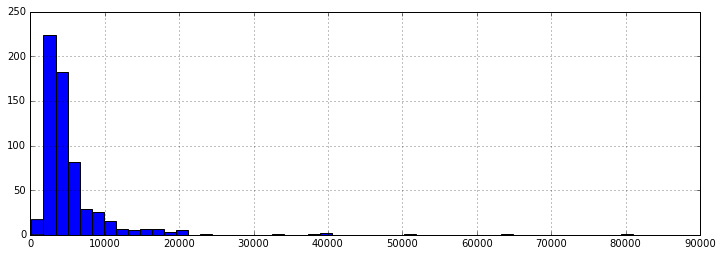

In [6]:
train.ApplicantIncome.hist(bins=50)

{'boxes': [<matplotlib.lines.Line2D at 0x119b653d0>],
 'caps': [<matplotlib.lines.Line2D at 0x119b74510>,
 'fliers': [<matplotlib.lines.Line2D at 0x119b81850>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x119b811d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x119b657d0>,
  <matplotlib.lines.Line2D at 0x119b65e90>]}

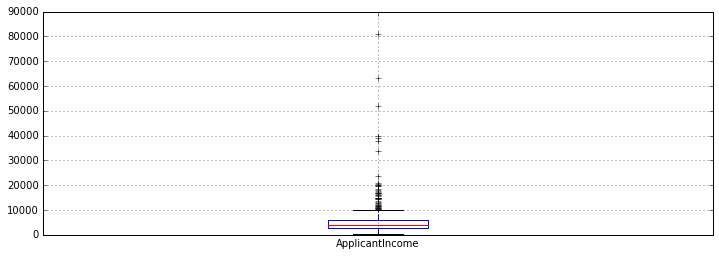

In [7]:
train.boxplot(column='ApplicantIncome')

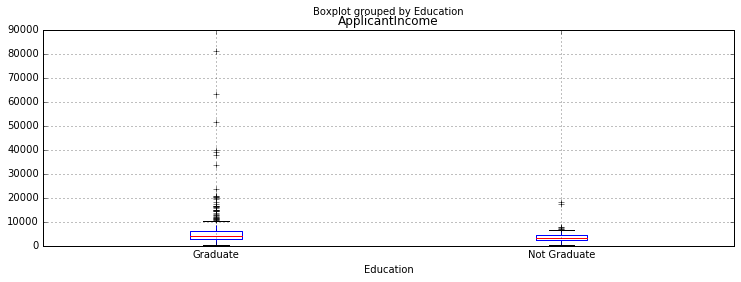

In [8]:
train.boxplot(column='ApplicantIncome', by='Education')

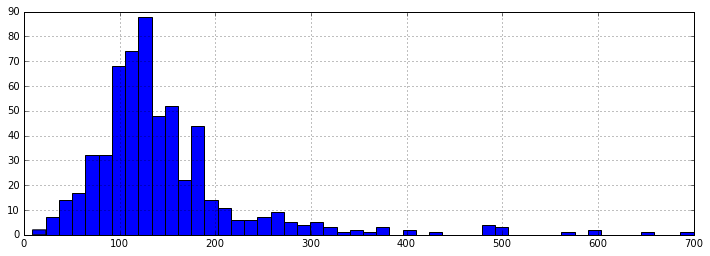

In [9]:
train.LoanAmount.hist(bins=50)

{'boxes': [<matplotlib.lines.Line2D at 0x11a4b9690>],
 'caps': [<matplotlib.lines.Line2D at 0x11a4c7750>,
 'fliers': [<matplotlib.lines.Line2D at 0x11a4d3a50>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x11a4d3410>],
 'whiskers': [<matplotlib.lines.Line2D at 0x11a4b9a10>,
  <matplotlib.lines.Line2D at 0x11a4c7110>]}

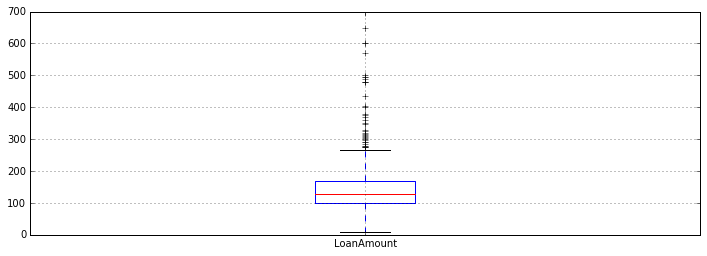

In [10]:
train.boxplot(column='LoanAmount')

In [11]:
train.groupby('Credit_History').mean()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
Credit_History,,,,
0.0,5679.438202,1542.179775,146.717647,341.927711
1.0,5426.526316,1528.250358,144.786026,342.192719


In [12]:
temp1 = train['Credit_History'].value_counts(ascending=True)
temp2 = train.pivot_table(values='Loan_Status',index=['Credit_History'],aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())
print 'Frequency Table for Credit History:' 
print temp1

print '\nProbility of getting loan for each Credit History class:' 
print temp2

Frequency Table for Credit History:
0.0     89
1.0    475
Name: Credit_History, dtype: int64

Probility of getting loan for each Credit History class:
Credit_History
0.0    0.078652
1.0    0.795789
Name: Loan_Status, dtype: float64


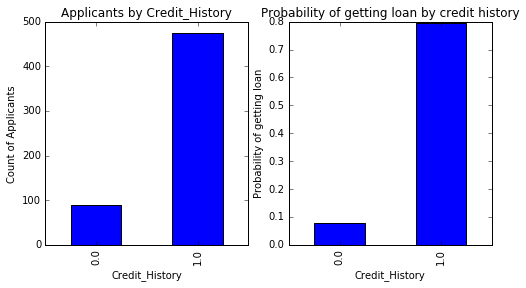

In [13]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('Credit_History')
ax1.set_ylabel('Count of Applicants')
ax1.set_title("Applicants by Credit_History")
temp1.plot(kind='bar')

ax2 = fig.add_subplot(122)
temp2.plot(kind = 'bar')
ax2.set_xlabel('Credit_History')
ax2.set_ylabel('Probability of getting loan')
ax2.set_title("Probability of getting loan by credit history")

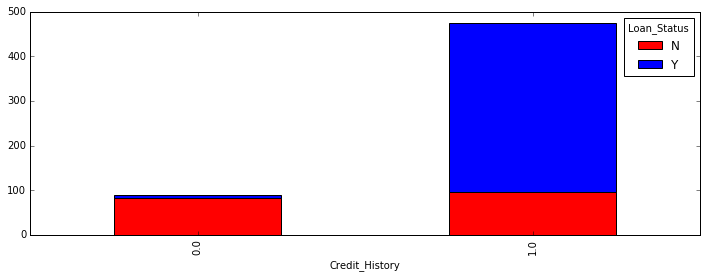

In [14]:
temp3 = pd.crosstab(train['Credit_History'], [train['Loan_Status']])
temp3.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)

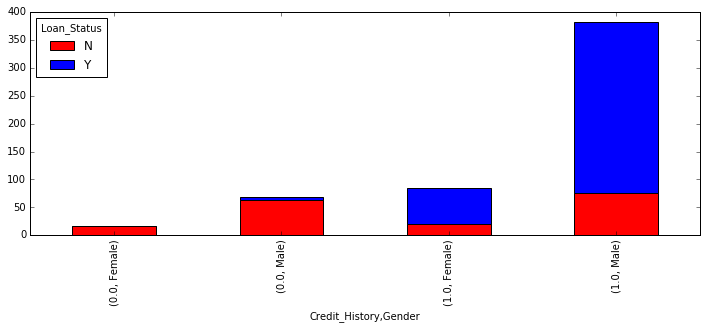

In [15]:
temp4 = pd.crosstab([train['Credit_History'], train['Gender']], train['Loan_Status'])
temp4.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)

In [16]:
train.apply(lambda x: sum(x.isnull()),axis=0) 

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

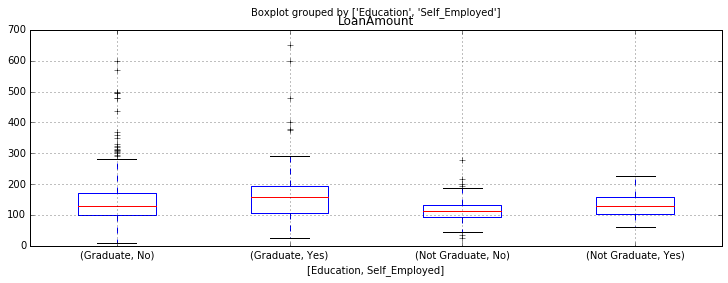

In [17]:
train.boxplot(column='LoanAmount', by=['Education', 'Self_Employed'])

In [18]:
%%time
train['Self_Employed'].fillna('No',inplace=True)

CPU times: user 741 µs, sys: 115 µs, total: 856 µs
Wall time: 764 µs


In [19]:
%%time
table = train.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)
# Define function to return value of this pivot_table
def fage(x):
 return table.loc[x['Self_Employed'],x['Education']]
# Replace missing values
train['LoanAmount'].fillna(train[train['LoanAmount'].isnull()].apply(fage, axis=1), inplace=True)

CPU times: user 14.6 ms, sys: 3.3 ms, total: 17.9 ms
Wall time: 15.1 ms


CPU times: user 90 ms, sys: 9.61 ms, total: 99.6 ms
Wall time: 93.9 ms


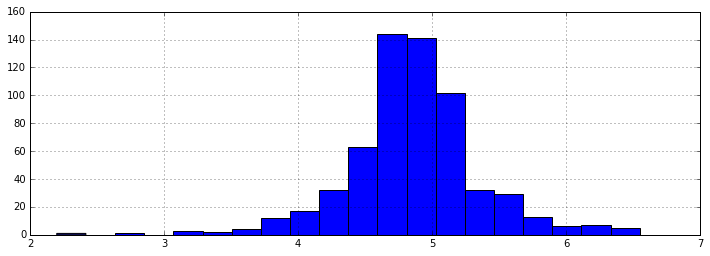

In [20]:
%%time
train['LoanAmount_log'] = np.log(train['LoanAmount'])
train['LoanAmount_log'].hist(bins=20)

CPU times: user 91.2 ms, sys: 5.91 ms, total: 97.1 ms
Wall time: 101 ms


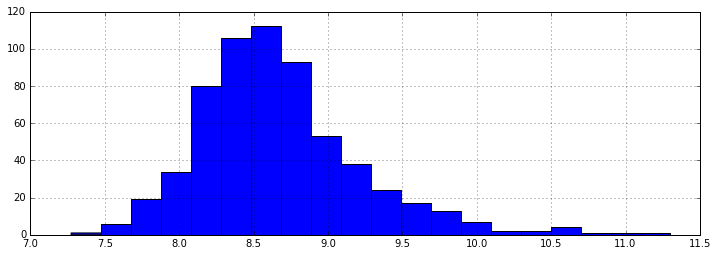

In [21]:
%%time
train['TotalIncome'] = train.ApplicantIncome + train.CoapplicantIncome
train['TotalIncome_log'] = np.log(train['TotalIncome'])
train['TotalIncome_log'].hist(bins=20)

In [22]:
train.apply(lambda x: sum(x.isnull()),axis=0) 

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
LoanAmount_log        0
TotalIncome           0
TotalIncome_log       0
dtype: int64

In [23]:
%%time
# train.Gender.fillna('Male', inplace=True)
# train.Married.fillna('Yes', inplace=True)
# train.Dependents.fillna(0, inplace=True)
# train.Loan_Amount_Term.fillna(360.0, inplace=True)
# train.Credit_History.fillna(1, inplace=True)
train.fillna(-1, inplace=True)
train['Payment_Percent'] = train.LoanAmount/train.TotalIncome
train['PayPercent_Log'] = train.LoanAmount_log/train.TotalIncome_log

CPU times: user 3.09 ms, sys: 730 µs, total: 3.82 ms
Wall time: 3.23 ms


In [24]:
%%time
cols_to_norm = ['ApplicantIncome','CoapplicantIncome', 'LoanAmount', 'LoanAmount_log', 
                'TotalIncome', 'TotalIncome_log', 'Payment_Percent', 'PayPercent_Log']
train[cols_to_norm] = train[cols_to_norm].apply(lambda x: (x - x.mean()) / (x.max() - x.min()))

CPU times: user 11.3 ms, sys: 2.27 ms, total: 13.5 ms
Wall time: 11.4 ms


In [25]:
%%time
train.Gender = le.fit_transform(train.Gender)
train.Married = le.fit_transform(train.Married)
train.Dependents = le.fit_transform(train.Dependents)
train.Education = le.fit_transform(train.Education)
train.Self_Employed = le.fit_transform(train.Self_Employed)
train.Property_Area = le.fit_transform(train.Property_Area)

CPU times: user 6.12 ms, sys: 1.12 ms, total: 7.24 ms
Wall time: 6.24 ms


In [26]:
%%time
train.Loan_Status = train.Loan_Status.map({'Y': 1, 'N': 0})

CPU times: user 1.49 ms, sys: 230 µs, total: 1.72 ms
Wall time: 1.53 ms


In [27]:
%%time
#Import models from scikit learn module:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

#Generic function for making a classification model and accessing performance:
def classification_model(model, data, predictors, outcome):
  #Fit the model:
  model.fit(data[predictors],data[outcome])
  
  #Make predictions on training set:
  predictions = model.predict(data[predictors])
  
  #Print accuracy
  accuracy = metrics.accuracy_score(predictions,data[outcome])
  print "Accuracy : %s" % "{0:.3%}".format(accuracy)

  #Perform k-fold cross-validation with 5 folds
  kf = KFold(data.shape[0], n_folds=5)
  error = []
  for train, test in kf:
    # Filter training data
    train_predictors = (data[predictors].iloc[train,:])
    
    # The target we're using to train the algorithm.
    train_target = data[outcome].iloc[train]
    
    # Training the algorithm using the predictors and target.
    model.fit(train_predictors, train_target)
    
    #Record error from each cross-validation run
    error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
 
  print "Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error))

  #Fit the model again so that it can be refered outside the function:
  model.fit(data[predictors],data[outcome]) 

CPU times: user 21 µs, sys: 1 µs, total: 22 µs
Wall time: 24.1 µs


In [28]:
%%time
features = features = [c for c in train.columns if c not in ['Loan_Status', 'Loan_ID']]
target = 'Loan_Status'

CPU times: user 45 µs, sys: 10 µs, total: 55 µs
Wall time: 52.9 µs


In [29]:
%%time
outcome_var = 'Loan_Status'
model = LogisticRegression()
predictor_var = ['Credit_History']
classification_model(model, train,features,outcome_var)

Accuracy : 68.241%
Cross-Validation Score : 67.589%
CPU times: user 47.5 ms, sys: 2.88 ms, total: 50.4 ms
Wall time: 52.1 ms


In [30]:
model = DecisionTreeClassifier()
predictor_var = ['Credit_History','Gender','Married','Education']
classification_model(model, train,features,outcome_var)

Accuracy : 100.000%
Cross-Validation Score : 72.308%


In [31]:
model = RandomForestClassifier(n_estimators=100)
predictor_var = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area',
        'LoanAmount_log','TotalIncome_log']
classification_model(model, train,features,outcome_var)

Accuracy : 100.000%
Cross-Validation Score : 79.315%


In [32]:
#Create a series with feature importances:
featimp = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
print featimp

Credit_History       0.226888
Payment_Percent      0.098439
PayPercent_Log       0.092463
TotalIncome_log      0.090199
TotalIncome          0.089760
ApplicantIncome      0.088254
LoanAmount_log       0.068778
LoanAmount           0.066003
CoapplicantIncome    0.052349
Property_Area        0.027027
Dependents           0.025117
Loan_Amount_Term     0.023971
Gender               0.014448
Married              0.014052
Education            0.013056
Self_Employed        0.009197
dtype: float64


In [33]:
model = RandomForestClassifier(n_estimators=25, min_samples_split=25, max_depth=7, max_features=1)
predictor_var = ['Credit_History','Payment_Percent','TotalIncome_log','LoanAmount_log','Dependents']
classification_model(model, train,features,outcome_var)

Accuracy : 79.642%
Cross-Validation Score : 69.543%


In [34]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics=['auc'], early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [35]:
%%time
target = 'Loan_Status'
IDcol = 'Loan_ID'

CPU times: user 4 µs, sys: 5 µs, total: 9 µs
Wall time: 9.06 µs


Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 14



Model Report
Accuracy : 0.9186
AUC Score (Train): 0.989225
CPU times: user 425 ms, sys: 3.98 ms, total: 429 ms
Wall time: 428 ms


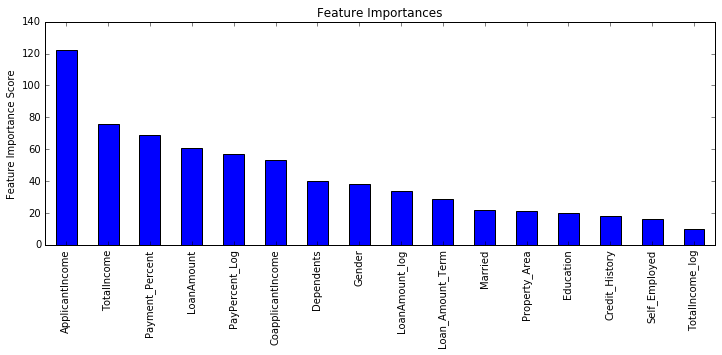

In [37]:
%%time
xgb4 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=8,
 min_child_weight=0,
 gamma=.1,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, features)

In [38]:
%%time
xgb_final = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=14,
 max_depth=8,
 min_child_weight=0,
 gamma=.1,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27).fit(train[features], train[target])

CPU times: user 20 ms, sys: 1.26 ms, total: 21.2 ms
Wall time: 20.4 ms


In [39]:
feat_imp = pd.Series(xgb_final.booster().get_fscore()).sort_values(ascending=False)
print feat_imp

ApplicantIncome      111
Payment_Percent       69
TotalIncome           68
LoanAmount            55
PayPercent_Log        54
CoapplicantIncome     50
Dependents            37
LoanAmount_log        34
Gender                34
Loan_Amount_Term      25
Married               22
Education             20
Property_Area         18
Credit_History        16
Self_Employed         15
TotalIncome_log       10
dtype: int64


In [40]:
test.apply(lambda x: sum(x.isnull()),axis=0) 

Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

In [41]:
%%time
test['Self_Employed'].fillna('No',inplace=True)

CPU times: user 777 µs, sys: 108 µs, total: 885 µs
Wall time: 800 µs


In [42]:
%%time
table = test.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)
# Define function to return value of this pivot_table
def fage(x):
 return table.loc[x['Self_Employed'],x['Education']]
# Replace missing values
test['LoanAmount'].fillna(test[test['LoanAmount'].isnull()].apply(fage, axis=1), inplace=True)

CPU times: user 10.7 ms, sys: 2.16 ms, total: 12.9 ms
Wall time: 11 ms


In [43]:
%%time
test['LoanAmount_log'] = np.log(test['LoanAmount'])

CPU times: user 765 µs, sys: 127 µs, total: 892 µs
Wall time: 797 µs


In [44]:
%%time
test['TotalIncome'] = test.ApplicantIncome + test.CoapplicantIncome
test['TotalIncome_log'] = np.log(test['TotalIncome'])

CPU times: user 1.88 ms, sys: 377 µs, total: 2.26 ms
Wall time: 1.92 ms


In [45]:
%%time
# test.Gender.fillna('Male', inplace=True)
# test.Married.fillna('Yes', inplace=True)
# test.Dependents.fillna(0, inplace=True)
# test.Loan_Amount_Term.fillna(360.0, inplace=True)
# test.Credit_History.fillna(1, inplace=True)
test.fillna(-1, inplace=True)

test['Payment_Percent'] = test.LoanAmount/test.TotalIncome
test['PayPercent_Log'] = test.LoanAmount_log/test.TotalIncome_log

CPU times: user 3.6 ms, sys: 1.01 ms, total: 4.61 ms
Wall time: 3.67 ms


In [46]:
cols_to_norm = ['ApplicantIncome','CoapplicantIncome', 'LoanAmount', 'LoanAmount_log', 
                'TotalIncome', 'TotalIncome_log', 'Payment_Percent', 'PayPercent_Log']
test[cols_to_norm] = test[cols_to_norm].apply(lambda x: (x - x.mean()) / (x.max() - x.min()))

In [47]:
%%time
test.Gender = le.fit_transform(test.Gender)
test.Married = le.fit_transform(test.Married)
test.Dependents = le.fit_transform(test.Dependents)
test.Education = le.fit_transform(test.Education)
test.Self_Employed = le.fit_transform(test.Self_Employed)
test.Property_Area = le.fit_transform(test.Property_Area)

CPU times: user 3.57 ms, sys: 688 µs, total: 4.25 ms
Wall time: 3.69 ms


In [48]:
test.apply(lambda x: sum(x.isnull()),axis=0) 

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
LoanAmount_log       0
TotalIncome          0
TotalIncome_log      0
Payment_Percent      0
PayPercent_Log       0
dtype: int64

In [49]:
# %%time
pred = xgb_final.predict(test[features])

In [50]:
%%time
submission = pd.DataFrame()
submission['Loan_ID'] = test.Loan_ID
submission['Loan_Status'] = pred
submission.Loan_Status = submission.Loan_Status.map({1:'Y',0:'N'})

CPU times: user 2.84 ms, sys: 514 µs, total: 3.36 ms
Wall time: 2.95 ms


In [51]:
%%time
submission.to_csv('submission.csv', index=False)

CPU times: user 1.31 ms, sys: 936 µs, total: 2.24 ms
Wall time: 1.49 ms
